In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv
from collections import defaultdict
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from collections import  Counter
import seaborn as sns
import string
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import gensim

In [4]:
def getPage(url):
    """
    Utilty function used to get a Beautiful Soup object from a given URL
    """

    session = requests.Session()
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36',
               'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'}
    try:
        req = session.get(url, headers=headers)
    except requests.exceptions.RequestException:
        return None
    bs = BeautifulSoup(req.text, 'html.parser')
    return bs

In [5]:
class Website:

    def __init__(self, name, url, targetPattern, absoluteUrl, titleTag, bodyTag):
        self.name = name
        self.url = url
        self.targetPattern = targetPattern
        self.absoluteUrl = absoluteUrl
        self.titleTag = titleTag
        self.bodyTag = bodyTag


class Content:

    def __init__(self, url, title, body):
        self.url = url
        self.title = title
        self.body = body

    def print(self):
        print('URL: {}'.format(self.url))
        print('TITLE: {}'.format(self.title))
        print('BODY:\n{}'.format(self.body))

In [6]:
import re
import time
result = {"url":[],   
          "title":[],  
          "content":[]
         }

class Crawler:
    def __init__(self, site):
        self.site = site
        self.visited = []

    def getPage(self, url):
        try:
            req = requests.get(url)
        except requests.exceptions.RequestException:
            return None
        return BeautifulSoup(req.text, 'html.parser')

    def safeGet(self, pageObj, selector):
        selectedElems = pageObj.select(selector)
        if selectedElems is not None and len(selectedElems) > 0:
            return '\n'.join([elem.get_text() for elem in selectedElems])
        return ''

    def parse(self, url):
        bs = self.getPage(url)
        if bs is not None:
            title = self.safeGet(bs, self.site.titleTag)
            body = self.safeGet(bs, self.site.bodyTag)
            if title != '' and body != '':
                content = Content(url, title, body)
                #content.print()
                result["url"].append(url)
                result["title"].append(title)
                result["content"].append(body)
                
                #words.append(body)
                #words_title.append(title)
                #links.append(url)

    def crawl(self):
        """
        Get pages from website home page
        """
        bs = self.getPage(self.site.url)
        targetPages = bs.findAll('a', href=re.compile(self.site.targetPattern))
        for targetPage in targetPages:
            targetPage = targetPage.attrs['href']
            if targetPage not in self.visited:
                self.visited.append(targetPage)
                if not self.site.absoluteUrl:
                    targetPage = '{}{}'.format(self.site.url, targetPage)
                self.parse(targetPage)

# Website: name, url, targetPattern, absoluteUrl, titleTag, bodyTag 
reuters = Website('Reuters', 'https://www.reuters.com', '^(/article/)',
                   False, 'h1', 'div.ArticleBodyWrapper')
crawler = Crawler(reuters)
crawler.crawl()
time.sleep(3)


In [7]:
reuters = Website('channelnewsasia', 'https://www.channelnewsasia.com', '^(/news/)',
                   False, 'h1', 'div.c-rte--article')
crawler = Crawler(reuters)
crawler.crawl()
time.sleep(3)

In [8]:
reuters = Website('cbc', 'https://www.cbc.ca', '^(/news/)',
                   False, 'h1', 'div.story')
crawler = Crawler(reuters)
crawler.crawl()
time.sleep(3)

In [9]:
reuters = Website('aljazeera', 'https://www.aljazeera.com', '^(/news/2020/)',
                   False, 'h1', 'div.wysiwyg')
crawler = Crawler(reuters)
crawler.crawl()
time.sleep(3)

In [10]:
print(len(result['url']))

91


In [11]:
class Content:
    """Common base class for all articles/pages"""

    def __init__(self, topic, url, title, body):
        self.topic = topic
        self.title = title
        self.body = body
        self.url = url

    def print(self):
        """
        Flexible printing function controls output
        """
        print('New article found for topic: {}'.format(self.topic))
        print('URL: {}'.format(self.url))
        print('TITLE: {}'.format(self.title))
        print('BODY:\n{}'.format(self.body))

In [12]:
class Website:
    """Contains information about website structure"""

    def __init__(self, name, url, searchUrl, resultListing, resultUrl, absoluteUrl, titleTag, bodyTag):
        self.name = name
        self.url = url
        self.searchUrl = searchUrl
        self.resultListing = resultListing
        self.resultUrl = resultUrl
        self.absoluteUrl = absoluteUrl
        self.titleTag = titleTag
        self.bodyTag = bodyTag

In [13]:
import requests
from bs4 import BeautifulSoup
a = []
b = []
c = []
class Crawler:

    def getPage(self, url):
        try:
            req = requests.get(url)
        except requests.exceptions.RequestException:
            return None
        return BeautifulSoup(req.text, 'html.parser')

    def safeGet(self, pageObj, selector):
        childObj = pageObj.select(selector)
        if childObj is not None and len(childObj) > 0:
            return childObj[0].get_text()
        return ''

    def search(self, topic, site):
        """
        Searches a given website for a given topic and records all pages found
        """
        bs = self.getPage(site.searchUrl + topic)
        searchResults = bs.select(site.resultListing)
        for result in searchResults:
            url = result.select(site.resultUrl)[0].attrs['href']
            # Check to see whether it's a relative or an absolute URL
            if(site.absoluteUrl):
                bs = self.getPage(url)
            else:
                bs = self.getPage(site.url + url)
            if bs is None:
                print('Something was wrong with that page or URL. Skipping!')
                return
            title = self.safeGet(bs, site.titleTag)
            body = self.safeGet(bs, site.bodyTag)
            if title != '' and body != '':
                #content = Content(topic, url, title, body)
                a.append(url)
                b.append(title)
                c.append(body)


crawler = Crawler()

#   siteData: [name, url, searchUrl, resultListing, resultUrl, absoluteUrl, titleTag, bodyTag]
siteData = [
            
    ['Economist', 'https://www.economist.com', 'https://www.economist.com/search?q=',
     'ol.layout-search-results li', 'a.search-result',True, 'h1', 'p.article__body-text'],

    ['O\'Reilly Media', 'http://oreilly.com', 'https://ssearch.oreilly.com/?q=',
        'article.result', 'p.title a', True, 'h1', 'div.product-description'],

    ['Brookings', 'http://www.brookings.edu', 'https://www.brookings.edu/search/?s=',
        'div.list-content article', 'h4.title a', True, 'h1', 'div.post-body'],

    ['Reuters', 'http://reuters.com', 'http://www.reuters.com/search/news?blob=', 'div.search-result-content',
        'h3.search-result-title a', False, 'h1', 'div.ArticleBodyWrapper']
]

sites = []
for row in siteData:
    sites.append(Website(row[0], row[1], row[2],
                         row[3], row[4], row[5], row[6], row[7]))

topics = ['climate', 'data', 'article', 'technology',
         'trump', 'china', 'covid', 'english','teacher', 'energy'] 


for topic in topics:
    print('GETTING INFO ABOUT: ' + topic)
    for targetSite in sites:
        crawler.search(topic, targetSite)

GETTING INFO ABOUT: climate
GETTING INFO ABOUT: data
GETTING INFO ABOUT: article
GETTING INFO ABOUT: technology
GETTING INFO ABOUT: trump
GETTING INFO ABOUT: china
GETTING INFO ABOUT: covid
GETTING INFO ABOUT: english
GETTING INFO ABOUT: teacher
GETTING INFO ABOUT: energy


In [14]:
for i in a:
    result["url"].append(i)
for i in b:
    result["title"].append(i)
for i in c:
    result["content"].append(i)

In [15]:
#save to csv
df = pd.DataFrame(result)
df.to_csv("/content/gdrive/My Drive/Data.csv", encoding="utf_8_sig")
#df=df.rename(columns={'name':'stu_name','class':'stu_class'})

In [16]:
df.shape[0]

406

In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/gdrive/My Drive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/gdrive/My Drive/H6752THP2.ipynb
/content/gdrive/My Drive/Data.csv
/content/gdrive/My Drive/H6752THP2.ipynb（副本）
/content/gdrive/My Drive/Data_r.csv
/content/gdrive/My Drive/Colab Notebooks/train_data_default.csv
/content/gdrive/My Drive/Colab Notebooks/Data_default.csv
/content/gdrive/My Drive/Colab Notebooks/submission.csv
/content/gdrive/My Drive/6751group/test_nolabel.csv
/content/gdrive/My Drive/6751group/train.csv
/content/gdrive/My Drive/6751group/tt1.csv
/content/gdrive/My Drive/6751group/tt0.csv
/content/gdrive/My Drive/6751group/hate_speech_2.ipynb


In [98]:
df = pd.read_csv('/content/gdrive/My Drive/Data.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,url,title,content
0,https://www.reuters.com/article/us-health-coro...,"U.S. COVID deaths top 250,000 as New York City...","By Gabriella Borter, Brendan O’Brien6 Min Read..."
1,https://www.reuters.com/article/us-usa-electio...,"Amid coronavirus spike, pressure grows on U.S....","By Andrea Shalal, Trevor Hunnicutt5 Min ReadWA..."
2,https://www.reuters.com/article/us-health-coro...,"Minnesota governor orders restaurants, bars to...",By Reuters Staff1 Min ReadFILE PHOTO: Minnesot...
3,https://www.reuters.com/article/us-health-coro...,Can COVID-19 testing allow us to gather safely...,By Reuters Staff5 Min ReadNEW YORK (Reuters) -...
4,https://www.reuters.com/article/us-usa-electio...,"Ahead of recount results, Georgia officials sa...",By Andy Sullivan3 Min ReadWASHINGTON (Reuters)...


In [99]:
print('There are {} rows and {} columns in csv file'.format(df.shape[0],df.shape[1]))

There are 406 rows and 3 columns in csv file


In [100]:
#combine the title and content
df['text'] = df['title'] + " " + df['content']
df = df.drop(columns = ['title', 'content'])
df = df.loc[~df['text'].isna()] 

In [77]:
df.head()

,url,text
0,https://www.reuters.com/article/us-health-coro...,"U.S. COVID deaths top 250,000 as New York City..."
1,https://www.reuters.com/article/us-usa-electio...,"Amid coronavirus spike, pressure grows on U.S...."
2,https://www.reuters.com/article/us-health-coro...,"Minnesota governor orders restaurants, bars to..."
3,https://www.reuters.com/article/us-health-coro...,Can COVID-19 testing allow us to gather safely...
4,https://www.reuters.com/article/us-usa-electio...,"Ahead of recount results, Georgia officials sa..."


In [101]:
#content before preprocessing
def create_corpus():
    corpus=[]
    
    for x in df['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

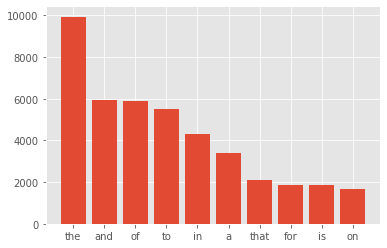

In [102]:
corpus=create_corpus()

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
#print(corpus)        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

In [103]:
stop_words = set(stopwords.words('english'))
to_remove = ['•', '!', '"', '#', '”', '“', '$', '%', '&', "'", '–', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '…']
stop_words.update(to_remove)
print('Number of stopwords:', len(stop_words))

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)




def clean_text(text):
    text = text.lower()
    #text = re.sub(r'http\S+', '', text)
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub('advertisement','',text)
    text = re.sub('reuters', '',text)
    text = re.sub('yes','', text)
    text = re.sub('‘','', text)
    text = re.sub('’','', text)
    text = re.sub('  ', ' ', text)
    #text = re.sub('[^a-zA-Z0-9]','',text)
    text = (" ").join([word for word in text.split() if not word in stop_words])
    text = "".join([char for char in text if not char in to_remove])
    return text



Number of stopwords: 226


In [104]:
df['text'] = df['text'].apply(clean_text)
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [105]:
df.to_csv("/content/gdrive/My Drive/Data_after.csv", encoding="utf_8_sig")
df.text

0      us covid deaths top  new york city schools hal...
1      amid coronavirus spike pressure grows us agenc...
2      minnesota governor orders restaurants bars hal...
3      covid testing allow us gather safely holidays ...
4      ahead recount results georgia officials say bi...
                             ...                        
401    briefmisen energy postpones agm staff min read...
402    energy dispute deepens mexico foreign allies d...
403    ukraine approves cuts green energy tariffs sta...
404    canadas tc energy ceo russ girling retire staf...
405    energy costs fall millions britons october sus...
Name: text, Length: 406, dtype: object

In [106]:
def create_corpus_1():
    corpus_1=[]
    for x in df['text'].str.split():
      for i in x:
        corpus_1.append(i)
    return corpus_1


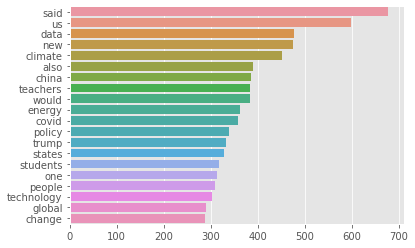

In [107]:
#after preprocess
from collections import Counter
import seaborn as sns
corpus_1=create_corpus_1()
counter=Counter(corpus_1)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:20]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

In [108]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

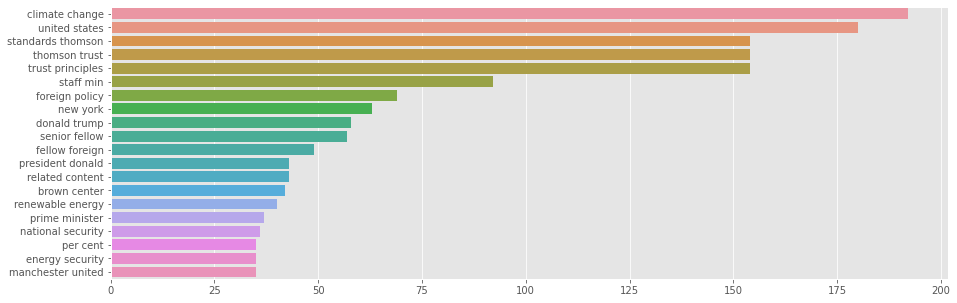

In [109]:
plt.figure(figsize=(15,5))
top_bigrams=get_top_bigrams(df['text'])[:20]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

In [86]:
from wordcloud import WordCloud, STOPWORDS
STOPWORDS.add('https')  # remove htps to the world Cloud
def Plot_world(text):    
    comment_words = ' '
    stopwords = set(STOPWORDS)   
    for val in text: 
        # typecaste each val to string 
        val = str(val) 
        # split the value 
        tokens = val.split() 
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '
    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

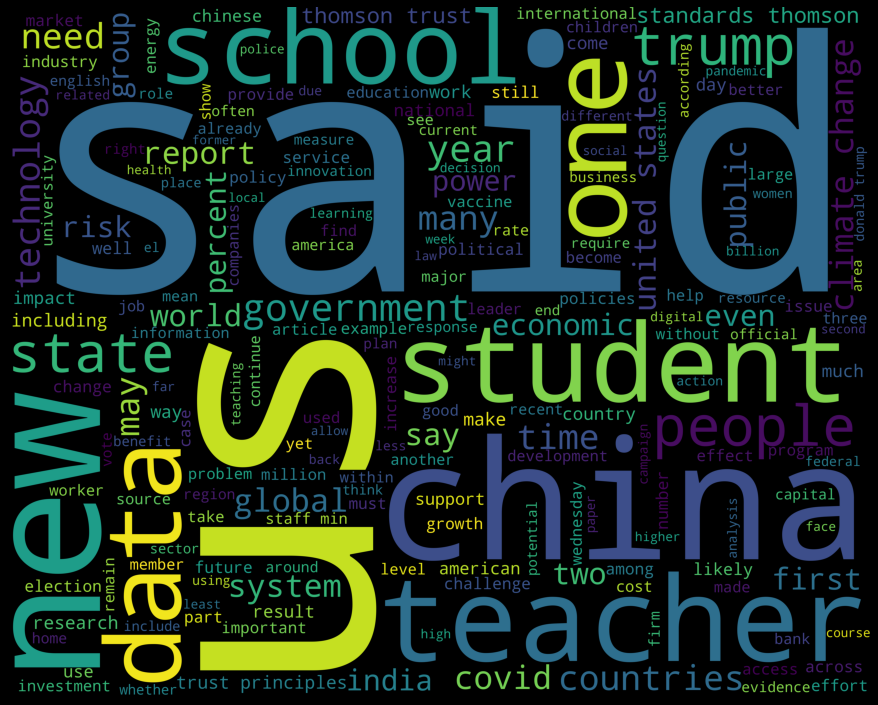

In [87]:

Plot_world(corpus_1)

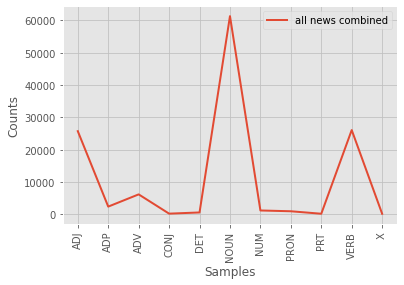

In [128]:
def create_corpus_2(text):
  words_new = str()   
  for i in text:
    words_new = words_new + i
  tokens = word_tokenize(words_new)


  pos = nltk.pos_tag(tokens, tagset='universal')
  tags = [b for (a, b) in pos]
#print(tags)
#fd = nltk.FreqDist(tags)


  cfd = nltk.ConditionalFreqDist()


  for word in tags:
    cfd['all news combined'][word] += 1

  cfd.plot()

corpus_2=create_corpus_2(df['text'])

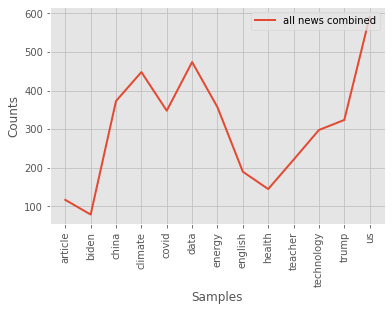

In [129]:
target_words = ["trump", "covid", "health", "biden", "us",'climate', 'data', 'article',
                'technology', 'china', 'english', 'teacher', 'energy']

cfd_1 = nltk.ConditionalFreqDist()  
words_new = str()   
         
for word_1 in df['text']:
  words_new = words_new + word_1
tokens = word_tokenize(words_new)   

for i in tokens:
  for words_1 in target_words:
    if words_1 == i:
        cfd_1['all news combined'][words_1] += 1 

cfd_1.plot()


In [33]:
df1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train_data_default.csv')
df1.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [34]:
df1['text'] = df1['Headline'] + " " + df1['Body']
df1 = df1.drop(columns = ['Headline', 'Body'])
df1 = df1.loc[~df1['text'].isna()] # 

In [35]:
df1['text'] = df1['text'].apply(clean_text)
df1['text']=df1['text'].apply(lambda x : remove_punct(x))

In [36]:
df1.head()

,URLs,Label,text
0,http://www.bbc.com/news/world-us-canada-414191...,1,four ways bob corker skewered donald trump ima...
1,https://www.reuters.com/article/us-filmfestiva...,1,linklaters war veteran comedy speaks modern am...
2,https://www.nytimes.com/2017/10/09/us/politics...,1,trumps fight corker jeopardizes legislative ag...
3,https://www.reuters.com/article/us-mexico-oil-...,1,egypts cheiron wins tieup pemex mexican onshor...
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,1,jason aldean opens snl vegas tribute country s...


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

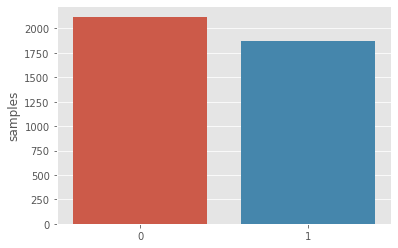

In [37]:
x=df1.Label.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

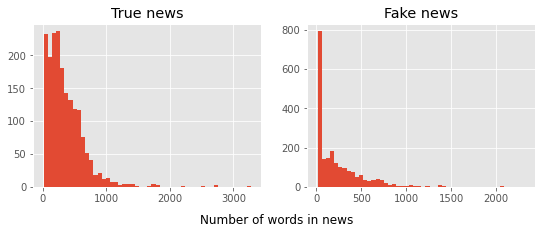

In [137]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(9,3))
text_len=df1[df1.Label==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len, bins = 50)
ax1.set_title('True news')
text_len=df1[df1.Label==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len, bins = 50)
ax2.set_title('Fake news')
fig.suptitle('Number of words in news', y=0)
fig.show()

In [110]:
text_train, text_test, y_train, y_test = train_test_split(df1['text'], df1['Label'], test_size = 0.2, random_state = 42) 

In [138]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
size_embedding = 200 #Dimensionality of the feature vectors
windows = 2 #Maximum distance between the current and predicted word within a sentence
min_count = 1 #Ignores words with total frequency lower than this
maxlen = 1000 #Length decided for the text (adjusted by padding and truncating)

text_train_splited = [article.split() for article in text_train]
w2v_model = gensim.models.Word2Vec(sentences = text_train_splited, 
                                   size = size_embedding, 
                                   window = windows, 
                                   min_count = min_count)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train_splited)
text_train_tok = tokenizer.texts_to_sequences(text_train_splited)
word_index = tokenizer.word_index
print('Size of vocabulary: ', len(word_index))

text_train_tok_pad = pad_sequences(text_train_tok, maxlen=maxlen)

Size of vocabulary:  47785


In [41]:
def w2v_to_keras_weights(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, size_embedding))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

embedding_vectors = w2v_to_keras_weights(w2v_model, word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [112]:
def set_model(embedding_vectors):
    model = Sequential()
    model.add(Embedding(embedding_vectors.shape[0], 
                        output_dim=embedding_vectors.shape[1],
                        weights=[embedding_vectors], 
                        input_length=maxlen, 
                        trainable=False))
    model.add(LSTM(units=32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

In [113]:
from keras.layers import Dense,Embedding,LSTM,Dropout
model = set_model(embedding_vectors)
model.summary()

history = model.fit(text_train_tok_pad, y_train, validation_split=0.2,
                    epochs=30, batch_size = 32, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         9557200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 9,587,057
Trainable params: 29,857
Non-trainable params: 9,557,200
_________________________________________________________________
Epoch 1/30
80/80 [==============================] - 4s 48ms/step - loss: 0.3979 - acc: 0.8437 - val_loss: 0.2778 - val_acc: 0.9028
Epoch 2/30
80/80 [==============================] - 3s 42ms/step - loss: 0.2414 - acc: 0.9091 - val_loss: 0.1772 - val_acc: 0.9248
Epoch 3/30
80/80 [==============================] - 4s 45ms/step - loss: 0.1974 - acc: 0.9228 - val_loss: 0

the train accuracy is :  0.9972570538520813
the validation accuracy is :  0.9655172228813171
the train loss is :  0.010836669243872166
the validtion loss is :  0.13665464520454407


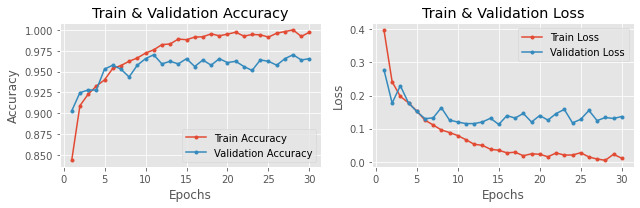

In [127]:
def plot_loss_epochs(history):
    epochs = np.arange(1,len(history.history['acc']) + 1,1)
    train_acc = history.history['acc']
    train_loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']

    fig , ax = plt.subplots(1,2, figsize=(9,3))
    ax[0].plot(epochs , train_acc , '.-' , label = 'Train Accuracy')
    ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
    ax[0].set_title('Train & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , '.-' , label = 'Train Loss')
    ax[1].plot(epochs , val_loss , '.-' , label = 'Validation Loss')
    ax[1].set_title('Train & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    fig.tight_layout()
    fig.show()
    print('the train accuracy is : ', train_acc[-1])
    print('the validation accuracy is : ', val_acc[-1])
    print('the train loss is : ', train_loss[-1])
    print('the validtion loss is : ', val_loss[-1])
plot_loss_epochs(history)


In [116]:
test_train_splited = [article.split() for article in df['text']]
w2v_model = gensim.models.Word2Vec(sentences = test_train_splited, 
                                   size = size_embedding, 
                                   window = windows, 
                                   min_count = min_count)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_train_splited)
test_train_tok = tokenizer.texts_to_sequences(test_train_splited)
word_index = tokenizer.word_index
#print('Sive of vocabulary: ', len(word_index))

test_train_tok_pad = pad_sequences(test_train_tok, maxlen=maxlen)


y_pre=model.predict(test_train_tok_pad)
y_pre=np.round(y_pre).astype(int).reshape(len(df['url']))
sub=pd.DataFrame({'url':df['url'],'text':df['text'],'target':y_pre})
sub.to_csv('/content/gdrive/My Drive/Colab Notebooks/submission.csv',index=False)



In [117]:
sub.head()

,url,text,target
0,https://www.reuters.com/article/us-health-coro...,us covid deaths top new york city schools hal...,1
1,https://www.reuters.com/article/us-usa-electio...,amid coronavirus spike pressure grows us agenc...,1
2,https://www.reuters.com/article/us-health-coro...,minnesota governor orders restaurants bars hal...,1
3,https://www.reuters.com/article/us-health-coro...,covid testing allow us gather safely holidays ...,1
4,https://www.reuters.com/article/us-usa-electio...,ahead recount results georgia officials say bi...,1


1    368
0     38
Name: target, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

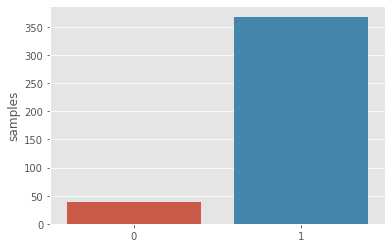

In [118]:
result=sub['target'].value_counts()
print(result)
sns.barplot(result.index,result)
plt.gca().set_ylabel('samples')

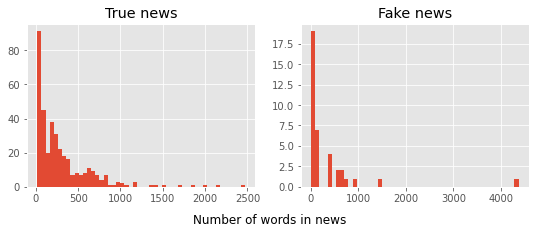

In [136]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(9,3))
text_len=sub[sub.target==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len, bins = 50)
ax1.set_title('True news')
text_len=sub[sub.target==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len, bins = 50)
ax2.set_title('Fake news')
fig.suptitle('Number of words in news', y=0)
fig.show()

In [48]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('averaged_perceptron_tagger')
import nltk
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [119]:
from textblob import TextBlob

scores = []


for i in df['text']:
  testimonial = TextBlob(i)
  scores.append(testimonial.sentiment.polarity)

print(scores)



[0.02197247572247572, 0.07653409090909091, 0.0, 0.12443806193806196, 0.048879097093382805, 0.11111793611793612, 0.007530663780663781, -0.0757703081232493, 0.013020833333333332, -0.0757703081232493, -0.007012516469038207, -0.024215367965367957, -0.040151515151515146, 0.051110537190082635, 0.08458571428571428, 0.11111793611793612, 0.13112244897959185, -0.020119047619047616, -0.0625, -0.09242424242424242, 0.009494949494949494, -0.031018518518518518, -0.02521929824561404, -0.07272727272727274, 0.007530663780663781, -0.0010582010582010622, 0.04264907135874878, 0.10955555555555556, 0.004005968778696053, 0.022981366459627325, 0.1516977813852814, 0.017380952380952375, -0.09242424242424242, 0.03388211382113821, -0.020119047619047616, -0.05132936507936506, 0.04598407544836116, 0.09166666666666666, -0.031018518518518518, 0.10955555555555556, -0.007012516469038207, -0.040151515151515146, 0.051110537190082635, 0.013020833333333332, -0.024215367965367957, 0.08458571428571428, 0.1747159090909091, -0.

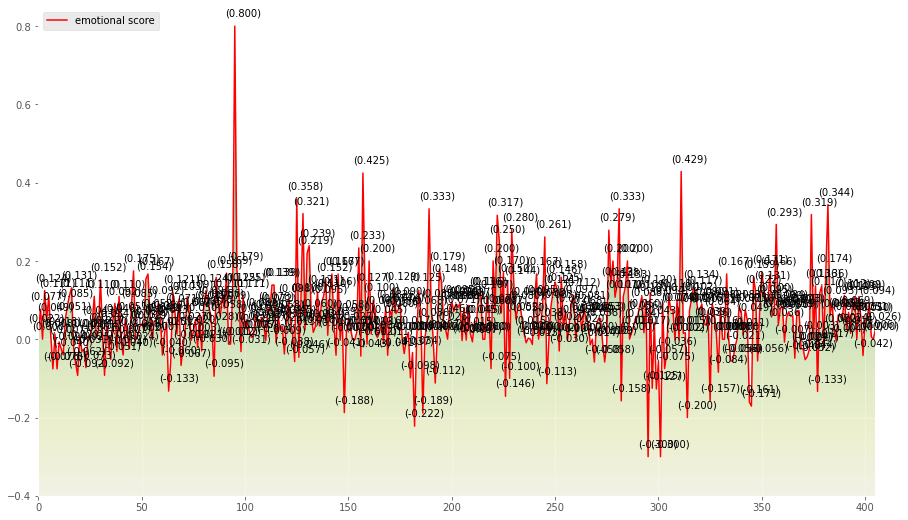

In [120]:

import matplotlib as mpl


fig, ax = plt.subplots(figsize=(15,9))     
plt.grid(alpha=0.4)

x = ([i for i in range(0,406,1)])

y = scores

_, yv = np.meshgrid(np.linspace(0,10,1500), np.linspace(0,1,900))

ax.fill_between(x, y, max(y)+0.05, color='white')
extent = [x[0], x[-1], -0.4, max(y)+0.05]
ax.imshow(yv, cmap=mpl.cm.YlGn, origin='lower',alpha = 0.5, aspect = 'auto',
          extent = extent)




plt.plot(x,y,label="emotional score",color = 'red')


for a,b in zip(x,y):
     plt.annotate('(%.3f)'%(b),xy=(a,b),xytext=(-10,10),textcoords='offset points')



plt.legend(loc="upper left")

plt.savefig('emotional score')
plt.show()

positive 289
negative 99
neutral 18


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Numbers')

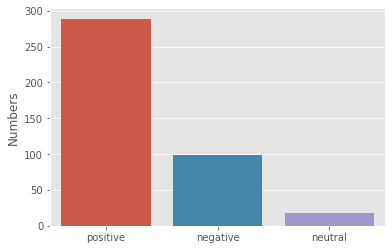

In [133]:
a = 0
b = 0
c = 0
for i in scores:
  if i > 0:
    a += 1
  elif i < 0:
    b += 1
  else:
    c += 1
print('positive', a)
print('negative', b)
print('neutral', c)

sns.barplot(['positive','negative','neutral'],[a,b,c])
plt.gca().set_ylabel('Numbers')

